In [1]:
# This file generates the data for Figure #4 from the paper https://arxiv.org/pdf/1806.06975.pdf

import os 
import pickle
import argparse
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt
from torch.autograd import Variable

from models.model_wrapper import WrappedModel
from data import datasets
from data.graph_wrapper import GeneInteractionGraph
from data.utils import record_result

/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Set the sample path depending on the location of your code and dataset.
# If it is unset, the TCGA dataset will be downloaded from Academic Torrents.
#dataset = datasets.GeneDataset(file_path="/data/lisa/data/genomics/TCGA/TCGA_tissue_ppi.hdf5")
dataset = datasets.GeneDataset(file_path="datastore/TCGA_tissue_ppi.hdf5")
#dataset = datasets.GeneDataset(at_hash="4070a45bc7dd69584f33e86ce193a2c903f0776d")

dataset.df = dataset.df - dataset.df.mean(axis=0)
label_df = dataset.df.where(dataset.df > 0).notnull().astype("int")



Converting one-hot labels to integers


In [22]:
# On which graphs will we run this experiment? Parameterize this. 
# you will need to add your graph to AcademicTorrents and put the hash into the get_at_hash function in data/graph.py
# or simply pass the path directly into graph.load_graph() below.
graph_paths = {"regnet": "/data/lisa/data/genomics/graph/kegg.hdf5", "genemania": "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"}
graphs = {}

for graph_name in graph_paths.keys():
    graph_path = GeneInteractionGraph.get_at_hash(graph_name) # otherwise use Academic Torrents to get the file
    #graph_path = graph_paths[graph_name] # When on Mila Network
    gene_graph = GeneInteractionGraph(graph_path)
    graphs[graph_name] = gene_graph


In [23]:
# Setup the results dictionary
filename = "experiments/results/fig-4.pkl"
try:
    results = pickle.load(open(filename, "r"))
    print "Loaded Checkpointed Results"
except Exception as e:
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'graph', 'is_first_degree', 'seed', 'train_size'])
    print "Created a New Results Dictionary"


Loaded Checkpointed Results


In [24]:
train_size = 50
test_size = 1000
trials = 3
cuda = False
models = [WrappedModel(name="MLP", column_names=dataset.df.columns, dropout=False, cuda=cuda)]


In [25]:
# Blacklist genes that do not have a good class balance
# class_balance = (label_df[gene].sum() / label_df.shape[0])

In [26]:
# Create the set of all experiment ids and see which are left to do
model_names = [model.name for model in models]
columns = ["gene", "graph", "model", "seed", "is_first_degree", "train_size"]
all_exp_ids = [x for x in itertools.product(dataset.df.columns, graphs.keys(), model_names, range(trials), [True, False], [train_size])]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")

print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 191205
done: 4435


In [28]:
for row in todo:
    if len(results) % 10 == 0:
        print(len(results))
    gene = row["gene"]
    graph_name = row["graph"]
    model_name = row["model"]
    seed = row["seed"]
    is_first_degree = row["is_first_degree"]
    model = [x for x in models if x.name == model_name][0]

    experiment = {
        "gene": gene,
        "model": model.name,
        "graph": graph_name,
        "is_first_degree": is_first_degree,
        "seed": seed,
        "train_size": train_size,
    }

    dataset.labels = label_df[gene]
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size)
    
    if is_first_degree:
        gene_graph = graphs[graph_name]
        neighbors = list(gene_graph.first_degree(gene)[0])
        X_train = X_train.loc[:, neighbors].copy()
        X_test = X_test.loc[:, neighbors].copy()
    else:
        X_train = X_train.copy()
        X_test = X_test.copy()
    X_train[gene] = 1
    X_test[gene] = 1

    try:
        model.fit(X_train, y_train)
        x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
        if cuda:
            x_test = x_test.cuda()
        y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
        auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
        model.best_model = None # cleanup
        experiment["auc"] = auc
    except Exception as e:
        print e
    results = record_result(results, experiment, filename)


The node EIF2B4 is not in the graph.
4600
The node EIF2B4 is not in the graph.
The node EIF2B4 is not in the graph.
4610
The node TMC8 is not in the graph.
The node TMC8 is not in the graph.
The node TMC8 is not in the graph.
4620
The node EIF2B1 is not in the graph.
The node EIF2B1 is not in the graph.
The node EIF2B1 is not in the graph.


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


4630
4640
The node CRYBG3 is not in the graph.
The node CRYBG3 is not in the graph.
The node CRYBG3 is not in the graph.
4650
4660
The node IFT140 is not in the graph.
The node IFT140 is not in the graph.
The node IFT140 is not in the graph.
4670
The node RSPH9 is not in the graph.
The node RSPH9 is not in the graph.
The node RSPH9 is not in the graph.
4680
The node TMEM14B is not in the graph.
The node TMEM14B is not in the graph.
The node TMEM14B is not in the graph.
4690
4700
The node MECOM is not in the graph.
The node MECOM is not in the graph.
The node MECOM is not in the graph.
The node ITGA2B is not in the graph.
The node ITGA2B is not in the graph.
4710
The node ITGA2B is not in the graph.


KeyboardInterrupt: 

In [10]:
# Compare the performance of each graph at predicting their neighbors
df = results

first_degree = df[df['is_first_degree'] == True][df['graph'] == 'genemania'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][df['graph'] == 'genemania'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
genemania_df = first_degree.sub(full).sort_values('mean', ascending=False)

first_degree = df[df['is_first_degree'] == True][df['graph'] == 'regnet'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][df['graph'] == 'regnet'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
regnet_df = first_degree.sub(full).sort_values('mean', ascending=False)


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


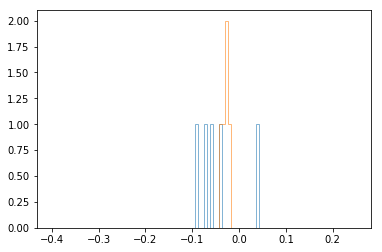

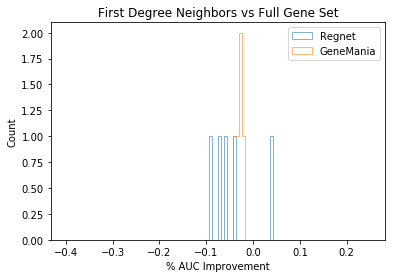

In [11]:

l1 = genemania_df['mean']
l2 = regnet_df['mean']

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", density=0, alpha=0.55, histtype='step')


fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", density=0, alpha=0.55, histtype='step')

plt.title("First Degree Neighbors vs Full Gene Set")
plt.ylabel("Count")
plt.xlabel("% AUC Improvement")

plt.legend()
plt.show()

,auc,gene_name,model,graph,is_first_degree,seed,train_size
